In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob, os
from numpy import pi, sqrt, cos, sin, radians, arcsin
%matplotlib widget

plt.ion()

def extract_from_txt(file_path, labels, delimiter='\n'):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_dict = {label: [] for label in labels}
    last_delimiter_index = 0
    messages = []
    for i in range(len(lines)):
        if(lines[i].startswith(delimiter)):
            messages.append(lines[last_delimiter_index:i])
            last_delimiter_index = i
    for message in messages:
        message_dict = {label: [] for label in labels}
        for label in labels:
            for line in message:
                    if(line.startswith(label)):
                        message_dict[label].append(float(line.split(':')[1]))
        full = True
        for key in message_dict:
            if(len(message_dict[key]) == 0):
                full=False
                break
        if(full):
            for label in labels:
                data_dict[label].append(message_dict[label][0])

    # for series in data_dict:
    #     print(series, len(data_dict[series]))

    df_raw = pd.DataFrame(data_dict)
    return df_raw

def remove_even_lines(input_file_path, output_file_path):
    with open(input_file_path, 'r') as file:
        lines = file.readlines()
    
    with open(output_file_path, 'w') as file:
        for i, line in enumerate(lines):
            if i % 2 == 0:
                file.write(line)

def butterworth_filter(data, cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

In [2]:
force_files = sorted(glob.glob(f"*.txt"))

dfs = []
for force_file in force_files:
    force_data_path = "filt/"+force_file[:-4] + '_filt.txt'
    remove_even_lines(force_file, force_data_path)
    df_force = extract_from_txt(
        force_data_path, 
        [
            'elapsed',
            'looptime',
            'N23', 
            'N67'
        ],
        '\n'
    )
    fs = 1/(df_force['looptime'].mean()*1e-6)
    # print(fs)
    df_force['N23_filt'] = butterworth_filter(df_force['N23'], 10, fs)
    df_force['N23'] = df_force['N23'] - df_force['N23_filt'][0]
    df_force['N23_filt'] = df_force['N23_filt'] - df_force['N23_filt'][0]
    dfs.append((df_force, force_file))
dfs[0][0]

,elapsed,looptime,N23,N67,N23_filt
0,8077.0,662.0,0.164186,-0.258180,0.000000
1,8078.0,661.0,0.232338,-0.215415,-0.005475
2,8079.0,662.0,0.276634,-0.182836,-0.011056
3,8079.0,662.0,0.353920,-0.199416,-0.016740
4,8080.0,662.0,0.362192,-0.129525,-0.022520
...,...,...,...,...,...
31616,29005.0,662.0,-0.187775,0.160095,-0.173194
31617,29005.0,662.0,-0.266362,0.133733,-0.173178
31618,29006.0,662.0,-0.259060,0.157534,-0.173165
31619,29007.0,661.0,-0.192254,0.098388,-0.173155


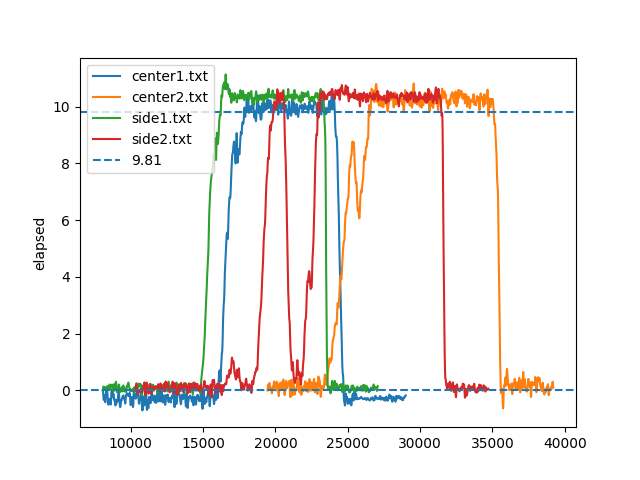

In [3]:
plt.figure()
for (df, name) in dfs:
    # plt.plot(df['elapsed'], df['N23'])
    plt.plot(df['elapsed'], df['N23_filt'], label=name)
plt.axhline(9.81, linestyle='--', label='9.81')
plt.axhline(0, linestyle='--')
plt.ylabel('newtons measured')
plt.ylabel('elapsed')
plt.legend()